## Explaining the Demand & Expected Earnings

Airbnb has successfully disrupted the traditional hospitality industry as more and more travelers decide to use Airbnb as their primary accommodation provider. Since its inception in 2008, Airbnb has seen an enormous growth, with the number of rentals listed on its website growing exponentially each year. However, it also means that the barrier for new player to join the market has been risen higher than ever before so new hosts need to think carefully about their strategy in order to become successful.

In Germany, no city is more popular than Berlin. That implies that Berlin is one of the hottest markets for Airbnb in Europe, with over 22,552 listings as of November 2018. With a size of 891 km², this means there are roughly 25 homes being rented out per km² in Berlin on Airbnb!

In this project, I will play the role of a consultant writing a letting guide for potential hosts that want to offer their accommodations in this vibrant city - Berlin. What could be a profitable option for them to offer their jewel on Airbnb? I would like to help them with their difficulty to know what the true value of their home is, and how in-demand their home might be. What is general trend(demand) of visitors each year? Moreover, since location and furniture are obviously fixed for the most part, is there anything else a host can influence - such as description, communication patterns, and/or additional services to boost their earnings?

The following question will drive this project:

> **How big is the demand likely to be? What can a host expect with respect to occupancy and earnings here in Berlin? What factors influence how in-demand it is?**

### The datasets

In this notebook, I will combine the summary listings and the detailed Berlin listings data, sourced from the Inside Airbnb website. The goal is to visualize the rental landscape and to try to understand the aspects influencing the demand. Both datasets were scraped on November 07th, 2018.

## Table of Contents
<a id='Table of contents'></a>

### <a href='#1. Obtaining and Viewing the Data'> 1. Obtaining and Viewing the Data </a>

### <a href='#2. Preprocessing the Data'> 2. Preprocessing the Data </a>
* <a href='#2.1. Standardizing data'> 2.1. Standardizing data </a>
* <a href='#2.2. Engineer Reviews per Month'> 2.2. Engineer Reviews per Month </a>
* <a href='#2.3. Combining Datasets'> 2.3. Combining Datasets </a>
* <a href='#2.4. Cleaning the Price Columns'> 2.4. Cleaning the Price Columns </a>
* <a href='#2.5. Occupancy Estimate'> 2.5. Occupancy Estimate </a>
* <a href='#2.6. Income Estimate'> 2.6. Income Estimate </a>

### <a href='#3. Exploratory Data Analysis (EDA)'> 3. Exploratory Data Analysis (EDA) </a>
* <a href='#3.1. Getting Started with a Heat Map'> 3.1. Getting Started with a Heat Map </a>
* <a href='#3.2. Seasonal Demand'> 3.2. Seasonal Demand </a>
* <a href='#3.3. Demand by Status SUPERHOST'> 3.3. Demand by Status SUPERHOST </a>
* <a href='#3.4. Demand by Neighbourhood'> 3.4. Demand by Neighbourhood </a>
* <a href='#3.5. Demand by Capacity'> 3.5. Demand by Capacity </a>
* <a href='#3.6. Wordclouds Reviews Summary'> 3.6. Wordclouds Reviews Summary </a>
* <a href='#3.7. Estimated Income vs Price'> 3.7. Estimated Income vs Price </a>

### <a href='#4. Interpreting the Data'> 4. Interpreting the Data </a>

### <a href='#5. Appendix'> 5. Appendix </a>

### 1. Obtaining and Viewing the Data 
<a id='1. Obtaining and Viewing the Data'></a>

Input data files are available in the "../input/" directory.

In [1]:
# This will be needed to work with maps
!pip install folium

In [2]:
# This is required for wordcloud
!pip install wordcloud

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import scipy
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
import folium
import datetime
import warnings
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline
pd.set_option('display.max_columns', 500)
mpl.style.use(['seaborn-darkgrid'])
warnings.filterwarnings('ignore')

In [4]:
df_listing_summ = pd.read_csv("C:/Users/ams-duongn.EXPEDITORS/Desktop/learn/Data Science Master/M4W4/input/listings_summary.csv")
print("listing_summ : " + str(df_listing_summ.shape))

listing_summ : (22552, 96)


In [5]:
df_rsumm = pd.read_csv("C:/Users/ams-duongn.EXPEDITORS/Desktop/learn/Data Science Master/M4W4/input/reviews_summary.csv")
print("reviews_summary : " + str(df_rsumm.shape))

reviews_summary : (401963, 6)


*Back to: <a href='#Table of contents'> Table of contents</a>*
### 2. Preprocessing the Data 
<a id='2. Preprocessing the Data'></a>

#### 2.1. Standardizing data
<a id='2.1. Standardizing data'></a>

In [6]:
#ignore unwanted columns like URLs
columns_to_keep = ['id','host_has_profile_pic','host_since',
                   'latitude', 'longitude','property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'price', 'cleaning_fee',
                   'security_deposit', 'minimum_nights',  
                   'instant_bookable', 'cancellation_policy','availability_365']
df_listing_summ = df_listing_summ[columns_to_keep].set_index('id')

In [7]:
print("listing_summ : " + str(df_listing_summ.shape))

listing_summ : (22552, 18)


* Check null values in each column
* Check $ sign; map t/f to 1/0
* Clean N/A values

In [8]:
df_listing_summ.isnull().sum()

host_has_profile_pic      26
host_since                26
latitude                   0
longitude                  0
property_type              0
room_type                  0
accommodates               0
bathrooms                 32
bedrooms                  18
bed_type                   0
amenities                  0
price                      0
cleaning_fee            7146
security_deposit        9361
minimum_nights             0
instant_bookable           0
cancellation_policy        0
availability_365           0
dtype: int64

In [9]:
#Convert f,t to 0 or 1
df_listing_summ['instant_bookable'] = df_listing_summ['instant_bookable'].map({'f':0,'t':1})

In [10]:
#fill f for N/A in host_has_profile_pic column for further correct mapping
set(df_listing_summ['host_has_profile_pic'])
df_listing_summ['host_has_profile_pic'].fillna('f',inplace=True)

In [11]:
#Convert f,t to 0 or 1
df_listing_summ['host_has_profile_pic'] = df_listing_summ['host_has_profile_pic'].map({'f':0,'t':1})

In [12]:
#Remove $ from price, fee columns and convert to float
df_listing_summ['price'] = df_listing_summ['price'].str.replace('$', '').str.replace(',', '').astype(float)
df_listing_summ['cleaning_fee'] = df_listing_summ['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype(float)
df_listing_summ['security_deposit'] = df_listing_summ['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)

In [13]:
#cleaning_fee cleanup of N/a replace with median value
df_listing_summ['cleaning_fee'].fillna(df_listing_summ['cleaning_fee'].median(), inplace=True)

In [14]:
#security_deposit cleanup of N/a replace with median value
df_listing_summ['security_deposit'].fillna(df_listing_summ['security_deposit'].median(), inplace=True)

In [15]:
#cleanup bathroom , bedroom columns
df_listing_summ['bathrooms'].fillna(1,inplace=True)
df_listing_summ['bedrooms'].fillna(1,inplace=True)

**Now I start building a correlation [](http://)of various factors that will influence price but before that lets remove any outliers**

In [16]:
#Check distribution of price column
df_listing_summ['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

**As we see above 75% of prices are near 70 Euros , but min is 0 & max is 9000. Lets drop anything above 200 and even price of 0 or 1 Euro doesnt make sense**

In [17]:
df_listing_summ.drop(df_listing_summ[ (df_listing_summ.price > 200) | (df_listing_summ.price == 0) | (df_listing_summ.price == 1) ].index, axis=0, inplace=True)
df_listing_summ['price'].describe()

count    22131.000000
mean        54.569608
std         33.197049
min          8.000000
25%         30.000000
50%         45.000000
75%         69.000000
max        200.000000
Name: price, dtype: float64

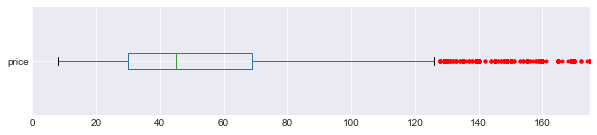

In [18]:
# boxplot of price column
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_listing_summ['price'].plot(kind='box', xlim=(0, 175), vert=False, flierprops=red_square, figsize=(10,2));

**Lets break up amenties that will help in drawing a correlation to price better as amenties might impact price**

In [19]:
df_listing_summ['No_of_amentities'] = df_listing_summ['amenities'].apply(lambda x:len(x.split(',')))

In [20]:
df_listing_summ['Laptop_friendly_workspace'] = df_listing_summ['amenities'].str.contains('Laptop friendly workspace')
df_listing_summ['TV'] = df_listing_summ['amenities'].str.contains('TV')
df_listing_summ['Family_kid_friendly'] = df_listing_summ['amenities'].str.contains('Family/kid friendly')
df_listing_summ['Host_greets_you'] = df_listing_summ['amenities'].str.contains('Host greets you')
df_listing_summ['Smoking_allowed'] = df_listing_summ['amenities'].str.contains('Smoking allowed')
df_listing_summ['Hot_water'] = df_listing_summ['amenities'].str.contains('Hot water')
df_listing_summ['Fridge'] = df_listing_summ['amenities'].str.contains('Refrigerator')

In [21]:
# dropping amenities as we have inferred above as different categories
dropped = ['amenities']
df_listing_summ.drop(dropped,axis=1,inplace=True)

In [22]:
#Convert false,true to 0 or 1
df_listing_summ['Laptop_friendly_workspace'] = df_listing_summ['Laptop_friendly_workspace'].astype(int)
df_listing_summ['TV'] = df_listing_summ['TV'].astype(int)
df_listing_summ['Family_kid_friendly'] = df_listing_summ['Family_kid_friendly'].astype(int)
df_listing_summ['Host_greets_you'] = df_listing_summ['Host_greets_you'].astype(int)
df_listing_summ['Smoking_allowed'] = df_listing_summ['Smoking_allowed'].astype(int)
df_listing_summ['Hot_water'] = df_listing_summ['Hot_water'].astype(int)
df_listing_summ['Fridge'] = df_listing_summ['Fridge'].astype(int)

**Lets also calculate distances from city center,airport and railway station that will again help in drawing a correlation to price**

In [23]:
#Calculate distance from central berlin
def haversine_distance_central(row):
    berlin_lat,berlin_long = radians(52.5200), radians(13.4050)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [24]:
#Calculate distance from airport
def haversine_distance_airport(row):
    berlin_lat,berlin_long = radians(52.3733), radians(13.5064)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [25]:
#Calculate distance from berlin railway station
def haversine_distance_rail(row):
    berlin_lat,berlin_long = radians(52.5073), radians(13.3324)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [26]:
df_listing_summ['distance_central'] = df_listing_summ.apply(haversine_distance_central,axis=1)
df_listing_summ['distance_airport'] = df_listing_summ.apply(haversine_distance_airport,axis=1)
df_listing_summ['distance_railways'] = df_listing_summ.apply(haversine_distance_rail,axis=1)
df_listing_summ['distance_avg'] = ( df_listing_summ['distance_central'] + df_listing_summ['distance_airport'] + df_listing_summ['distance_railways'] )/3.0

** Now we  are ready to see price is dependent on how many factors for top 1000 properties; so first I will sort by price descending and then generate a correlation matrix **

In [27]:
df_listing_summ.sort_values(by='price',ascending=False,axis=0,inplace=True) #sorting frame by price desc

In [28]:
df_list_summ_top10000 = df_listing_summ.head(10000)
df_list_summ_top1000 = df_listing_summ.head(1000)

#### 2.2. Engineer Reviews per Month
<a id='2.2. Engineer Reviews per Month'></a>

*1. Process the date column and create a new dataframe*

In [29]:
# drop unnecessary columns in reviews summary:
df_rsumm.drop(['reviewer_name'], axis=1, inplace=True)

# rename id column and replace current value simply with 1 to later count the # of reviews per accommodation
df_rsumm.rename({'id':'review_count'}, axis=1, inplace=True)
df_rsumm.review_count = 1

# checking shape and duplicates
print("The first dataset has {} rows and {} columns.".format(*df_rsumm.shape))
print("It contains {} duplicates.".format(df_rsumm.duplicated().sum()))

df_rsumm.head(2)

The first dataset has 401963 rows and 5 columns.
It contains 0 duplicates.


listing_id  review_count        date  reviewer_id  \
0        2015             1  2016-04-11      7178145   
1        2015             1  2016-04-15     41944715   

                                            comments  
0  Mein Freund und ich hatten gute gemütliche vie...  
1  Jan was very friendly and welcoming host! The ...

In [30]:
df_rsumm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401963 entries, 0 to 401962
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   listing_id    401963 non-null  int64 
 1   review_count  401963 non-null  int64 
 2   date          401963 non-null  object
 3   reviewer_id   401963 non-null  int64 
 4   comments      401467 non-null  object
dtypes: int64(3), object(2)
memory usage: 15.3+ MB


In [31]:
# cast date-column from current object datatype to datetime datatype
df_rsumm.date = pd.to_datetime(df_rsumm.date, format="%Y-%m-%d")

Let's take the most consecutive 12 months we can get a hold of. As the scraping took place on November 07th 2018, we can have a full year starting November 1st, 2017 and ending October 31st, 2018:

In [32]:
count_2017_18 = df_rsumm[df_rsumm["date"].isin(pd.date_range('2017-11-01', '2018-10-31'))]
print("The dataset 2017/2018 has {} reviews and {} columns.".format(*count_2017_18.shape))

The dataset 2017/2018 has 165873 reviews and 5 columns.


In [33]:
# set the date as index and sort by index
count_2017_18 = count_2017_18.set_index('date').sort_index()

In [34]:
# group by month and listing_id, i.e. specific apartment                      
count_2017_18_monthly = count_2017_18.groupby([pd.Grouper(freq='M'), 'listing_id'])['review_count'].count().reset_index()

#initial check
count_2017_18_monthly.head()

# set column review_count to reviews_per_month
count_2017_18_monthly.rename(columns={"review_count": "reviews_per_month"}, inplace=True)

# set date as index again
count_2017_18_monthly.set_index('date', inplace=True)

# check again
count_2017_18_monthly.head()

listing_id  reviews_per_month
date                                     
2017-11-30        3309                  1
2017-11-30        7071                  2
2017-11-30       17409                  3
2017-11-30       17904                  3
2017-11-30       22415                  2

In [35]:
# get rid of date index
count_2017_18_monthly = count_2017_18_monthly.reset_index()

# group by listing_id and count reviews, turn it into a dataframe without groupby index
count_2017_18_monthly = pd.DataFrame(count_2017_18_monthly.groupby('listing_id')['reviews_per_month'].mean()\
                                                          .reset_index())

count_2017_18_monthly.head()

listing_id  reviews_per_month
0        2015           2.888889
1        2695           2.000000
2        3309           1.000000
3        7071           3.454545
4        9991           1.000000

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.2. Combining Datasets
<a id='2.2. Combining Datasets'></a>

In [36]:
#import listings summary table again for merging purpose
df_2 = pd.read_csv('C:/Users/ams-duongn.EXPEDITORS/Desktop/learn/Data Science Master/M4W4/input/listings_summary.csv')
df_2.head()

id                        listing_url       scrape_id last_scraped  \
0  2015  https://www.airbnb.com/rooms/2015  20181107122246   2018-11-07   
1  2695  https://www.airbnb.com/rooms/2695  20181107122246   2018-11-07   
2  3176  https://www.airbnb.com/rooms/3176  20181107122246   2018-11-07   
3  3309  https://www.airbnb.com/rooms/3309  20181107122246   2018-11-07   
4  7071  https://www.airbnb.com/rooms/7071  20181107122246   2018-11-07   

                                               name  \
0  Berlin-Mitte Value! Quiet courtyard/very central   
1                Prenzlauer Berg close to Mauerpark   
2                   Fabulous Flat in great Location   
3                 BerlinSpot Schöneberg near KaDeWe   
4                  BrightRoom with sunny greenview!   

                                             summary  \
0  Great location!  30 of 75 sq meters. This wood...   
1                                                NaN   
2  This beautiful first floor apartment  is situa...   
3  First of all: I prefer short-notice bookings. ...   
4  Cozy and large room in the beautiful district ...   

                                               space  \
0  A+++ location! This „Einliegerwohnung“ is an e...   
1  In the summertime we are spending most of our ...   
2  1st floor (68m2) apartment on Kollwitzplatz/ P...   
3  Your room is really big and has 26 sqm, is ver...   
4  The BrightRoom is an approx. 20 sqm (215ft²), ...   

                                         description experiences_offered  \
0  Great location!  30 of 75 sq meters. This wood...                none   
1  In the summertime we are spending most of our ...                none   
2  This beautiful first floor apartment  is situa...                none   
3  First of all: I prefer short-notice bookings. ...                none   
4  Cozy and large room in the beautiful district ...                none   

                               neighborhood_overview  \
0  It is located in the former East Berlin area o...   
1                                                NaN   
2  The neighbourhood is famous for its variety of...   
3  My flat is in the middle of West-Berlin, direc...   
4  Great neighborhood with plenty of Cafés, Baker...   

                                               notes  \
0  This is my home, not a hotel. I rent out occas...   
1                                                NaN   
2  We welcome FAMILIES and cater especially for y...   
3  The flat is a strictly non-smoking facility! A...   
4  I hope you enjoy your stay to the fullest! Ple...   

                                             transit  \
0  Close to U-Bahn U8 and U2 (metro), Trams M12, ...   
1  Within walking distance you'll find the S-Bahn...   
2  We are 5 min walk  away from the tram M2, whic...   
3  The public transportation is excellent: Severa...   
4  Best access to other parts of the city via pub...   

                                              access  \
0  Simple kitchen/cooking, refrigerator, microwav...   
1  Außer deinem Zimmer kannst du noch die Küche u...   
2  The apartment will be entirely yours. We are c...   
3  I do have a strictly non-smoker-flat.  Keep th...   
4  The guests have access to the bathroom, a smal...   

                                         interaction  \
0                                   Always available   
1                                                NaN   
2  Feel free to ask any questions prior to bookin...   
3  I'm working as a freelancing photographer. My ...   
4  I am glad if I can give you advice or help as ...   

                                         house_rules  thumbnail_url  \
0  No parties No events No pets No smoking, not e...            NaN   
1                                                NaN            NaN   
2  It’s a non smoking flat, which likes to be tre...            NaN   
3  House-Rules and Information ..............(deu...            NaN   
4  Please take good care of everything during you...

In [37]:
# merge full 2017/2018 dataframe + add specific columns from df_2
df = pd.merge(count_2017_18_monthly, df_2[['id', 'price', 'cleaning_fee', 'neighbourhood_group_cleansed', 
                          'latitude', 'longitude', 'property_type', 'accommodates', 
                          'bathrooms', 'bedrooms', 'bed_type', 'host_is_superhost']], 
              left_on='listing_id', right_on='id')

# drop 'id' from right dataframe as it's the same as 'listing_id' on the left dataframe
df.drop(['id'], axis=1, inplace=True)

# shorten the name of one column
df.rename({'neighbourhood_group_cleansed':'neighbourhood'}, axis=1, inplace=True)

# check the dataframe
print("The dataset has {} rows and {} columns - after combining it.".format(*df.shape))
print("It contains {} duplicates.".format(df.duplicated().sum()))
df.head(2)

The dataset has 13609 rows and 13 columns - after combining it.
It contains 0 duplicates.


listing_id  reviews_per_month   price cleaning_fee neighbourhood  \
0        2015           2.888889  $60.00       $30.00         Mitte   
1        2695           2.000000  $17.00        $0.00        Pankow   

    latitude  longitude property_type  accommodates  bathrooms  bedrooms  \
0  52.534537  13.402557    Guesthouse             3        1.0       1.0   
1  52.548513  13.404553     Apartment             2        1.0       1.0   

   bed_type host_is_superhost  
0  Real Bed                 t  
1  Real Bed                 f

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.3. Cleaning the Price Columns
<a id='2.3. Cleaning the Price Columns'></a>

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13609 entries, 0 to 13608
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         13609 non-null  int64  
 1   reviews_per_month  13609 non-null  float64
 2   price              13609 non-null  object 
 3   cleaning_fee       10794 non-null  object 
 4   neighbourhood      13609 non-null  object 
 5   latitude           13609 non-null  float64
 6   longitude          13609 non-null  float64
 7   property_type      13609 non-null  object 
 8   accommodates       13609 non-null  int64  
 9   bathrooms          13596 non-null  float64
 10  bedrooms           13601 non-null  float64
 11  bed_type           13609 non-null  object 
 12  host_is_superhost  13607 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 1.5+ MB


As we can see above, `price` and `cleaning_fee` are both string columns, with the latter containing substantial null values that most likely mean that these hoste do not charge cleaning fees. Let's quickly tidy up here:

In [39]:
# convert price column into numeric value
df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float).astype(int)
df.price.isna().sum()

0

In [40]:
# replace missing values with zero and convert cleaning_fee column into numeric value
df.cleaning_fee.fillna('$0.00', inplace=True)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float).astype(int)
df.cleaning_fee.isna().sum()

0

In [41]:
# investigate price column
df['price'].describe()

count    13609.000000
mean        65.109045
std        158.996457
min          0.000000
25%         33.000000
50%         49.000000
75%         73.000000
max       8600.000000
Name: price, dtype: float64

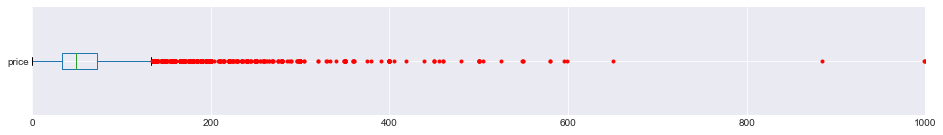

In [42]:
# boxplot of price column
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

The boxplot above shows quite a skewed distribution with a long tail of high-priced outliers. However, 75% of all rentals only cost up to 70 Euro. For this project, let's remove the extremely high priced rentals above € 300/night to maintain comparability.

In [43]:
df.drop(df[df['price'] > 300].index, axis=0, inplace=True)
df['price'].describe()

count    13526.000000
mean        59.243457
std         40.413352
min          0.000000
25%         33.000000
50%         49.000000
75%         70.000000
max        300.000000
Name: price, dtype: float64

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.4. Occupancy Estimate
<a id='2.4. Occupancy Estimate'></a>

One of the biggest issues with Airbnb is getting the occupancy rate for each host or for a market. *Inside Airbnb*, the website I sourced the data from, uses an occupancy model which they call the "San Francisco Model" with the following methodology:

1. A **Review Rate** of 50% is used to convert reviews to estimated bookings. Other administrative authorities are said to use a review rate of 72% (however this may be attributed to an unreliable source: Airbnb's CEO and co-founder Brian Chesky) - or one of 30.5% (based on comparing public data of reviews to the The New York Attorney General’s report on Airbnb released in October 2014.) *Inside Airbnb* chose 50% as it sits almost exactly between 72% and 30.5%. It basically means that only 50% of all visitors write a review. With that said, the number of reviews per month divided by the review rate equals an estimate of actual visitors.
2. An **average length of stay** for each city is usually published by Airbnb. This number multiplied by the estimated bookings for each listing over a period of time gives **the occupancy rate**.
3. Finally, the **income** can be calculated by multiplying the occupancy rate by the price and the time period of interest - here, 12 months:

>**Monthly Occupancy Rate = Average Length of Stay * (No. of reviews per Month / Review Rate)**<br>
*According to the latest Airbnb update, guests who booked stays in Berlin in 2017 via Airbnb spent 4.2 nights here on average.*

>**Yearly Income = Monthly Occupancy Rate * Price * 12 Months**

*Modest Estimate*

With a very modest review rate of 0.5, we are assuming that only every second guest left a review. While I could see many more than just half the visitors actually writing feedback, let's calculate this conservative estimate first:

In [44]:
avg_length_of_stay_berlin = 4.2
review_rate_modest = 0.5

# calculate the occupancy and round the result
df['modest_occupancy'] = round(avg_length_of_stay_berlin * (df['reviews_per_month']/review_rate_modest), 2)

# occupancy cannot be greater than 100% - are there any mistakes?
len(df[df['modest_occupancy'] > 100])

4

In [45]:
# let's drop occupancy rates > 100
df.drop(df[(df['modest_occupancy'] > 100)].index, axis=0, inplace=True)

# check the distribution
df['modest_occupancy'].describe()

count    13522.000000
mean        17.885419
std         11.570805
min          8.400000
25%          8.400000
50%         14.000000
75%         22.400000
max         98.700000
Name: modest_occupancy, dtype: float64

*Optimistic Estimate*

Now let's try for a more optimistic estimate of occupancy using a review rate of 0.4, which assumes that only 40% of all guests left a review. This way, the number of reviews points to a higher occupancy than in the modest estimate we had before:

In [46]:
review_rate_optimistic = 0.4

# calculate the occupancy and round the result
df['optimistic_occupancy'] = round(avg_length_of_stay_berlin * (df['reviews_per_month']/review_rate_optimistic), 2)

# occupancy cannot be greater than 100% - are there any mistakes?
len(df[df['optimistic_occupancy'] > 100])

13

In [47]:
# let's drop the occupancy rates > 100
df.drop(df[(df['optimistic_occupancy'] > 100)].index, axis=0, inplace=True)

# check the distribution
df['optimistic_occupancy'].describe()

count    13509.000000
mean        22.274628
std         14.224291
min         10.500000
25%         10.500000
50%         17.500000
75%         28.000000
max         99.750000
Name: optimistic_occupancy, dtype: float64

*Comparing Occupancy Estimates*

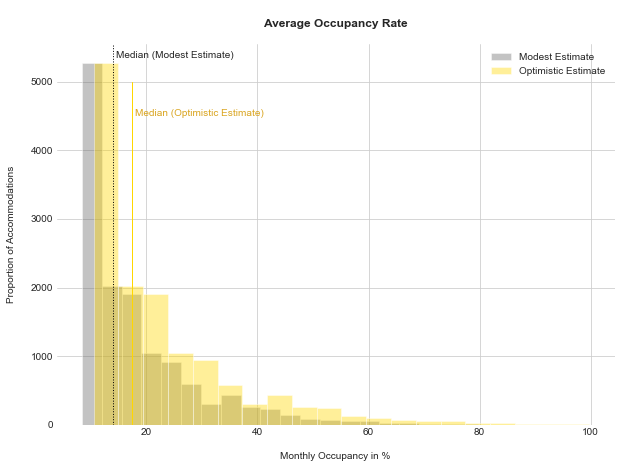

In [48]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,7))

sns.distplot(df['modest_occupancy'], kde=False, bins=20, color='dimgrey')
sns.distplot(df['optimistic_occupancy'], kde=False, bins=20, color='gold')

plt.title('\nAverage Occupancy Rate\n', fontweight='bold')
plt.legend(['Modest Estimate', 'Optimistic Estimate'])
plt.xlabel('\nMonthly Occupancy in %')
plt.ylabel('Proportion of Accommodations\n')

# draw and label a line with median value of modest estimate
plt.axvline(x=14, ymin=0, ymax=1, linewidth=1, linestyle=':', color='black')
plt.text(14.5, 5350, 'Median (Modest Estimate)')

# draw and label a line with median value of optimistic estimate
plt.axvline(x=17.5, ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='gold')
plt.text(18, 4500, 'Median (Optimistic Estimate)', color='goldenrod');

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.5. Income Estimate
<a id='2.5. Income Estimate'></a>

Using our modest and optimistic estimates for the occupancy rate, we'll now do the same for income:

In [49]:
df['modest_income'] = df['modest_occupancy'] * df['price'] * 12
df.modest_income.describe()

count     13509.000000
mean      12711.697002
std       13078.961619
min           0.000000
25%        5040.000000
50%        8709.120000
75%       15120.000000
max      241113.600000
Name: modest_income, dtype: float64

In [50]:
df['optimistic_income'] = df['optimistic_occupancy'] * df['price'] * 12
df.optimistic_income.describe()

count     13509.000000
mean      15889.597273
std       16348.762861
min           0.000000
25%        6300.000000
50%       10886.400000
75%       18900.000000
max      301392.000000
Name: optimistic_income, dtype: float64

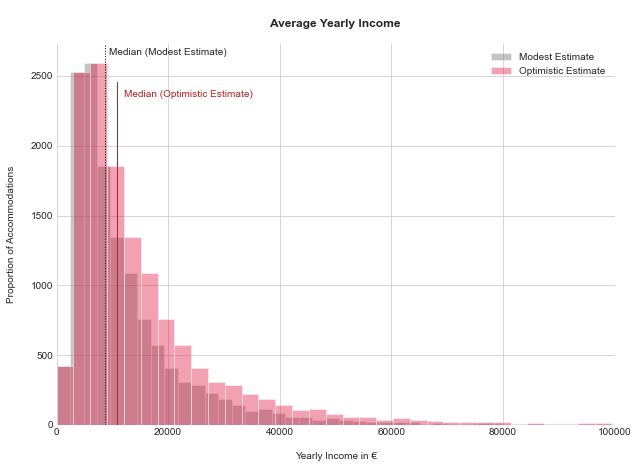

In [51]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,7))

sns.distplot(df['modest_income'], kde=False, bins=100, color='dimgrey')
sns.distplot(df['optimistic_income'], kde=False, bins=100, color='crimson')

plt.title('\nAverage Yearly Income\n', fontweight='bold')
plt.legend(['Modest Estimate', 'Optimistic Estimate'])
plt.xlabel('\nYearly Income in €')
plt.xlim((0,100000))
plt.ylabel('Proportion of Accommodations\n')

# draw and label a line with median value of modest estimate
plt.axvline(x=8709, ymin=0, ymax=1, linewidth=1, linestyle=':', color='black')
plt.text(9350, 2650, 'Median (Modest Estimate)')

# draw and label a line with median value of optimistic estimate
plt.axvline(x=10886, ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='firebrick')
plt.text(12000, 2350, 'Median (Optimistic Estimate)', color='firebrick');

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 3. Exploratory Data Analysis (EDA)
<a id='3. Exploratory Data Analysis (EDA)'></a>

#### 3.1. Getting Started with a Heat Map
<a id='3.1. Getting Started with a Heat Map'></a>

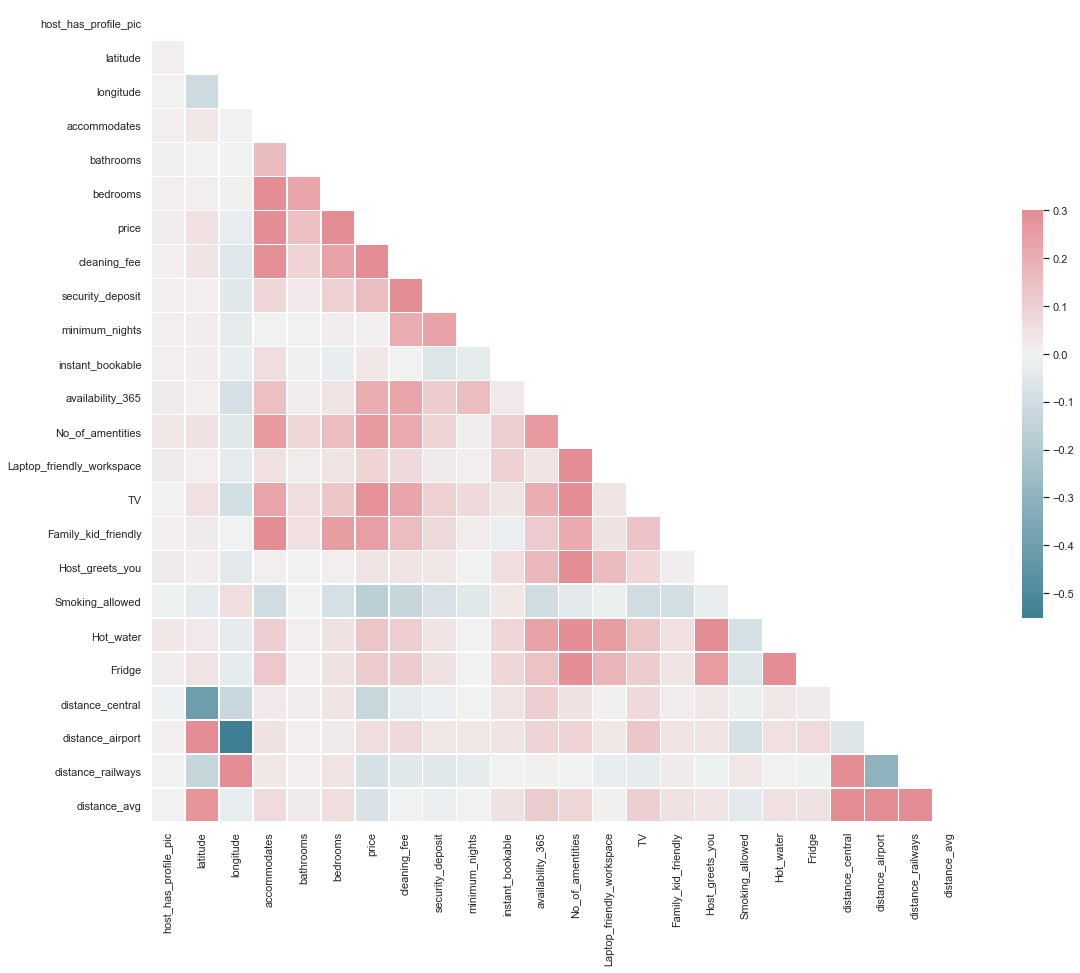

In [52]:
sns.set(style="white")
corr = df_listing_summ.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 15))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5},cbar=True);

Above matrix clearly tells us that price seems to depend largely on following factors: 
* No. of amenities
* Is it family or kids friendly
* Cleaning fee
* the number of people that can be `accommodated` as an indicator for **size or capacity**
* Presence of core amenities (e.g. bathrooms, bedrooms, TV)
* Whether the rental property is available year-round (`availability_365`)

Above matrix also tells us that price is not much dependent on distance

I assume there might be also some **seasonality** that strongly influences the demand. Furthermore, I believe that the so-called **super host status** does benefit these hosts, who probably get far more guests than standard hosts. As the heat map only uses numeric columns, it can't show any such relationship — so let's walk through all of these factors to visually investigate their effect on demand in later sections.

Lets gets p-values & pearson's coefficients for price w.r.t. some columns to support our above premise.
p-values indicate the degree of correlation between 2 variables with statistical definitions as below:
* p-value is < 0.001: we say there is strong evidence that the correlation is significant.
* the p-value is < 0.05: there is moderate evidence that the correlation is significant.
* the p-value is < 0.1: there is weak evidence that the correlation is significant.
* the p-value is > 0.1: there is no evidence that the correlation is significant.

In [53]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['accommodates'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient between accommodates and price is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient between accommodates and price is 0.5361159603905183  with a P-value of P = 0.0


In [54]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['security_deposit'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient between security_deposit and price is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient between security_deposit and price is 0.15924029542431684  with a P-value of P = 1.276767104657841e-125


In [55]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['No_of_amentities'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient between No_of_amentities and price is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient between No_of_amentities and price is 0.26628050133217224  with a P-value of P = 0.0


Now We are going to plot all top 1000 properties on a map to see where they are concentrated (central berlin, railway station or airport)

In [56]:
# Setting a base map
lat = 52.509
long = 13.381
base = folium.Map(location=[lat,long], zoom_start=12) #base map setting
base

In [57]:
neighbourhoods = folium.map.FeatureGroup()

In [58]:
lat_long_list = [[52.520,13.405],[52.373,13.506],[52.507,13.332]] #locatioms of central berlin , railway stn, airport

In [59]:
for i in range(0,len(lat_long_list)):
    neighbourhoods.add_child(
        folium.CircleMarker(
        lat_long_list[i],
        radius = 16,
        color='yellow',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
        )
    )
base.add_child(neighbourhoods)

In [60]:
neighbourhoods = folium.map.FeatureGroup()
for inc_lat,inc_long in zip(df_list_summ_top1000.longitude,df_list_summ_top1000.latitude):
    neighbourhoods.add_child(
    folium.CircleMarker(
    [inc_long,inc_lat],
    radius = 5,
    color='yellow',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6
    )
)
base.add_child(neighbourhoods)

* Above map plot indicates top 1000 properties are around central berlin & railway station and very few near airport
* This is also evident from below distribution plots where properties are mostly around central berlin & railway station

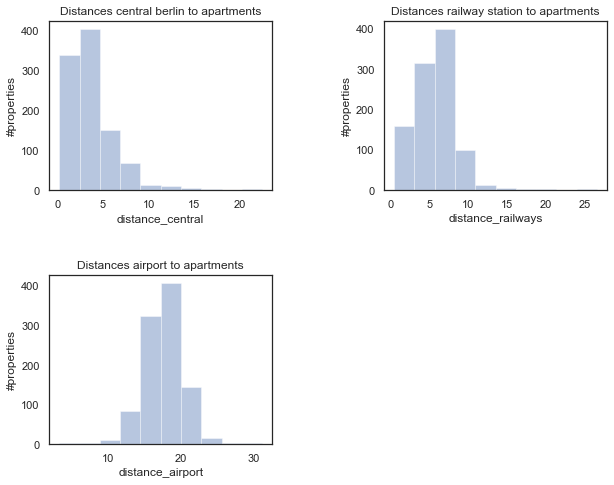

In [61]:
fig = plt.figure(figsize=(10,6))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)

sns.distplot(df_list_summ_top1000["distance_central"], bins=10, kde=False,ax=ax0)
ax0.set_title('Distances central berlin to apartments')
ax0.set_xlabel('distance_central')
ax0.set_ylabel('#properties')

sns.distplot(df_list_summ_top1000["distance_railways"], bins=10, kde=False,ax=ax1)
ax1.set_title('Distances railway station to apartments')
ax1.set_xlabel('distance_railways')
ax1.set_ylabel('#properties')

sns.distplot(df_list_summ_top1000["distance_airport"], bins=10, kde=False,ax=ax2)
ax2.set_title('Distances airport to apartments')
ax2.set_xlabel('distance_airport')
ax2.set_ylabel('#properties')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.5)
plt.show()

> ** So far we have worked on listing data-set. Now lets work on reviews summary and see what in-sights we can gather from it **

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.2. Seasonal Demand
<a id='3.2. Seasonal Demand'></a>

**I am going to generate month, day, year columns and then generate few line charts to see which month/year had most no. of visitors **

In [62]:
def mapper(month):
    date = datetime.datetime(2000, month, 1)  # You need a dateobject with the proper month
    return date.strftime('%b')  # %b returns the months abbreviation, other options [here][1]

In [63]:
df_rsumm['date'] = pd.to_datetime(df_rsumm['date'])
df_rsumm['year'] = df_rsumm['date'].dt.year
df_rsumm['month'] = df_rsumm['date'].dt.month
df_rsumm['day'] = df_rsumm['date'].dt.day

df_rsumm['year'] = df_rsumm['year'].astype(int)
df_rsumm['month'] = df_rsumm['month'].astype(int)
df_rsumm['day'] = df_rsumm['day'].astype(int)

In [64]:
df_rsumm.sort_values(['year', 'month'], ascending=[True, True],axis=0,inplace=True) #sorting frame by year,month asc

In [65]:
df_rsumm['month'] = df_rsumm['month'].apply(mapper) ##convert month to month name

** I am creating a shallow copy of my frame (means changes in main frame dont affect this copy) as I will need to work on original frame with comments data for some sentiment analysis later **

In [66]:
df_rsumm_orig = df_rsumm.copy(deep=False) 

In [67]:
df_rsumm['year'].value_counts()

2018    152448
2017    111799
2016     69303
2015     39470
2014     17702
2013      7422
2012      3092
2011       617
2010       107
2009         3
Name: year, dtype: int64

Looking at above value counts ; lets do visitor trend (demand) analysis for 2015,2016,2017,2018 so lets filter the main frame

In [68]:
df_2015 = df_rsumm[df_rsumm['year'] == 2015]
df_2016 = df_rsumm[df_rsumm['year'] == 2016]
df_2017 = df_rsumm[df_rsumm['year'] == 2017]
df_2018 = df_rsumm[df_rsumm['year'] == 2018]

In [69]:
dropped = ['year','day','date','listing_id']
df_2015.drop(dropped,axis=1,inplace=True)
df_2016.drop(dropped,axis=1,inplace=True)
df_2017.drop(dropped,axis=1,inplace=True)
df_2018.drop(dropped,axis=1,inplace=True)

In [70]:
df_2015["count"] = df_2015.groupby("month")["reviewer_id"].transform('count')
df_2016["count"] = df_2016.groupby("month")["reviewer_id"].transform('count')
df_2017["count"] = df_2017.groupby("month")["reviewer_id"].transform('count')
df_2018["count"] = df_2018.groupby("month")["reviewer_id"].transform('count')

In [71]:
dropped = ['reviewer_id']
df_2015.drop(dropped,axis=1,inplace=True)
df_2016.drop(dropped,axis=1,inplace=True)
df_2017.drop(dropped,axis=1,inplace=True)
df_2018.drop(dropped,axis=1,inplace=True)
df_2015 = df_2015.drop_duplicates()
df_2016 = df_2016.drop_duplicates()
df_2017 = df_2017.drop_duplicates()
df_2018 = df_2018.drop_duplicates()
df_2015=df_2015.reset_index(drop=True)
df_2016=df_2016.reset_index(drop=True)
df_2017=df_2017.reset_index(drop=True)
df_2018=df_2018.reset_index(drop=True)

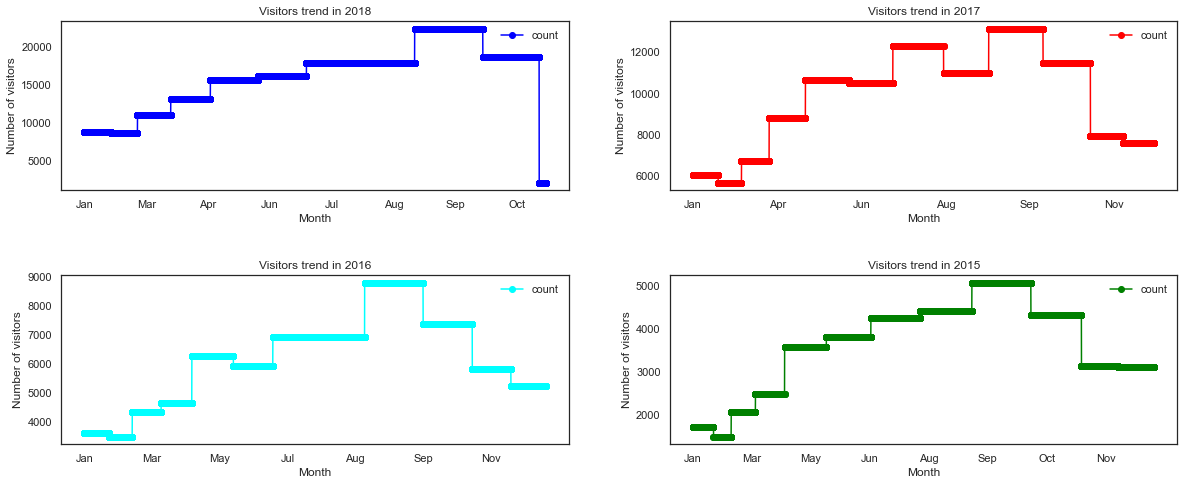

In [72]:
fig = plt.figure(figsize=(20, 6))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

df_2018.plot(kind='line', color='blue', x='month',y='count',marker='o',ax=ax0) # add to subplot 1
ax0.set_title('Visitors trend in 2018')
ax0.set_xlabel('Month')
ax0.set_ylabel('Number of visitors')

df_2017.plot(kind='line', color='red', x='month',y='count',marker='o',ax=ax1) # add to subplot 2
ax1.set_title('Visitors trend in 2017')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of visitors')

df_2016.plot(kind='line', color='cyan', x='month',y='count',marker='o',ax=ax2) # add to subplot 3
ax2.set_title('Visitors trend in 2016')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of visitors')

df_2015.plot(kind='line', color='green', x='month',y='count',marker='o',ax=ax3) # add to subplot 4
ax3.set_title('Visitors trend in 2015')
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of visitors')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5)
plt.show()

**Above plots indicate visitors have always peaked (most demand) during Sep each year**

Be aware that - unlike the other plots - the one for 2018 only ranges from January to October! 

Having said that, we can see the same pattern each and every year: the visitors peak from May to July, and then again in September and October. It drops significantly during August and the winter months. The pattern in August is interesting: tourists seem to avoid city trips for sightseeing like Berlin, probably preferring to go on beach holidays.

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.3. Demand by Status SUPERHOST
<a id='3.3. Demand by Status SUPERHOST'></a>

In [73]:
# check super host column for NaN's
df.host_is_superhost.isna().sum()

2

In [74]:
# replace NaN's with value 'false' for not being a superhost
df.host_is_superhost.fillna(value='f', inplace=True)
df.host_is_superhost.isna().sum()

0

*What do the differences between super hosts and standard hosts look like?*

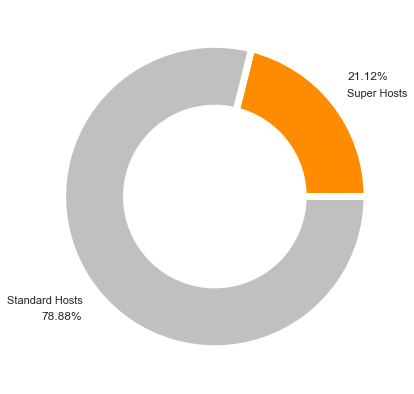

In [75]:
# assign the data
super_host    = df.host_is_superhost.value_counts()['t']
no_super_host = df.host_is_superhost.value_counts()['f']
names = ['Super Hosts','Standard Hosts']
size  = [super_host, no_super_host]

# create a pie chart
plt.pie(size, labels=names, colors=['darkorange','silver'], 
        autopct='%.2f%%', pctdistance=1.28,
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.show()

In [76]:
# the overall median differences between superhosts and standard hosts
df.groupby('host_is_superhost')['modest_occupancy'].agg(np.median)

host_is_superhost
f    12.6
t    21.0
Name: modest_occupancy, dtype: float64

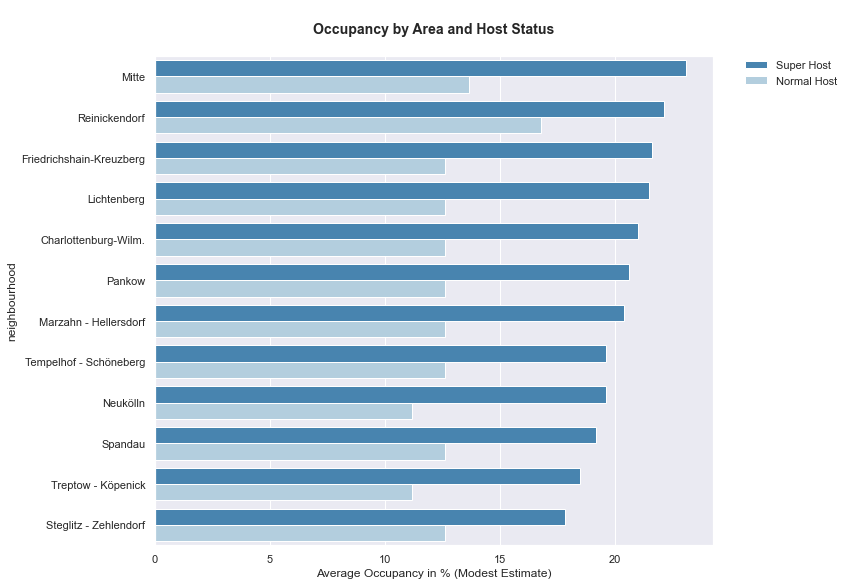

In [77]:
# group by neighbourhood and by status, then take the median occupancy
df_grouped = pd.DataFrame(df.groupby(['neighbourhood', 'host_is_superhost'])['modest_occupancy'].agg(np.median))
df_grouped.sort_values(by='modest_occupancy', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)

# plot grouped dataframe with seaborn
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 9))
sns.barplot(x='modest_occupancy', y='neighbourhood', hue='host_is_superhost', hue_order=['t', 'f'], 
            data=df_grouped, palette="Blues_r")

# add title and axis label
ax.set_title('\nOccupancy by Area and Host Status\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Average Occupancy in % (Modest Estimate)')

# rename legend labels & put legend outside plot
handles, labels = ax.get_legend_handles_labels()
ax.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(1.05, 1), borderaxespad=0.);

It's definitely worth aspiring to become a super host! The differences in occupancy and income are striking!

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.4. Demand by Neighbourhood
<a id='3.4. Demand by Neighbourhood'></a>

*Lollipop Charts with two observations*

In [78]:
def lollipop_with_2(dataframe, about, y_col, x1_col, x2_col):
    ''' Function that creates a lollipop chart with 
    two observations (x-values) per group (y-value). '''
       
    # set style
    sns.set_style("dark")
    
    # prepare data
    df_plot = dataframe[[y_col, x1_col, x2_col]].groupby(y_col).apply(lambda x: x.mean())
    df_plot.sort_values(x1_col, inplace=True)
    df_plot.reset_index(inplace=True)
        
    # draw plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.hlines (y=df_plot.index, xmin=df_plot[x1_col], xmax=df_plot[x2_col], color='grey', alpha=0.7, linewidth=2)
    ax.scatter(y=df_plot.index, x=df_plot[x1_col], s=75, color='skyblue', alpha=0.7, label=x1_col)
    ax.scatter(y=df_plot.index, x=df_plot[x2_col], s=75, color='darkblue', alpha=0.7, label=x2_col)
    ax.legend()
    
    # title, label, ticks and xlim
    ax.set_title('\nAverage ' + about + ' by District\n', fontdict={'size':12, 'weight':'bold'})
    ax.set_xlabel('\n' + about)
    ax.set_yticks(df_plot.index)
    ax.set_yticklabels(df_plot[y_col], rotation=0, 
                       fontdict={'horizontalalignment': 'right', 'size':12})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

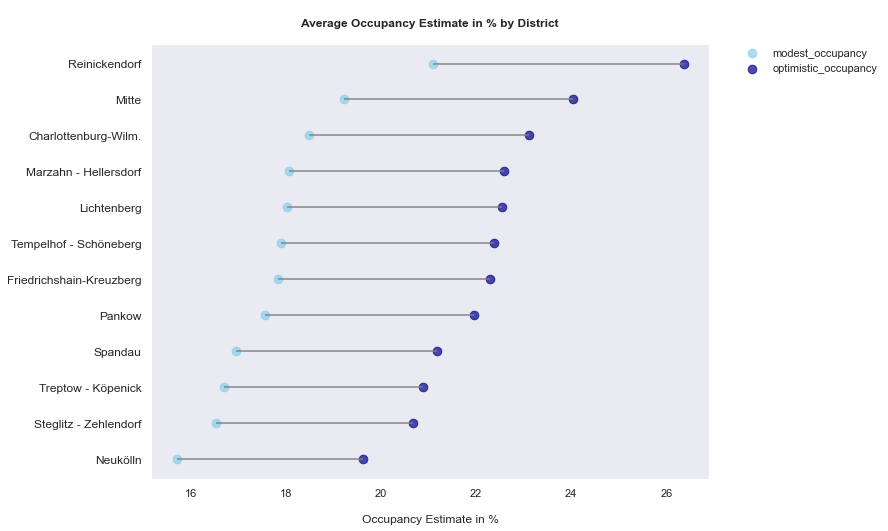

In [79]:
lollipop_with_2(df, 'Occupancy Estimate in %', 'neighbourhood', 'modest_occupancy', 'optimistic_occupancy')

Unsurprisingly, *Mitte* is the most in-demand area; it's a hotspot, right in the center, and close to most places of interest. However, unexpectedly, why is *Reinickendorf* - a district quite far away from the city center at the top for occupancy?

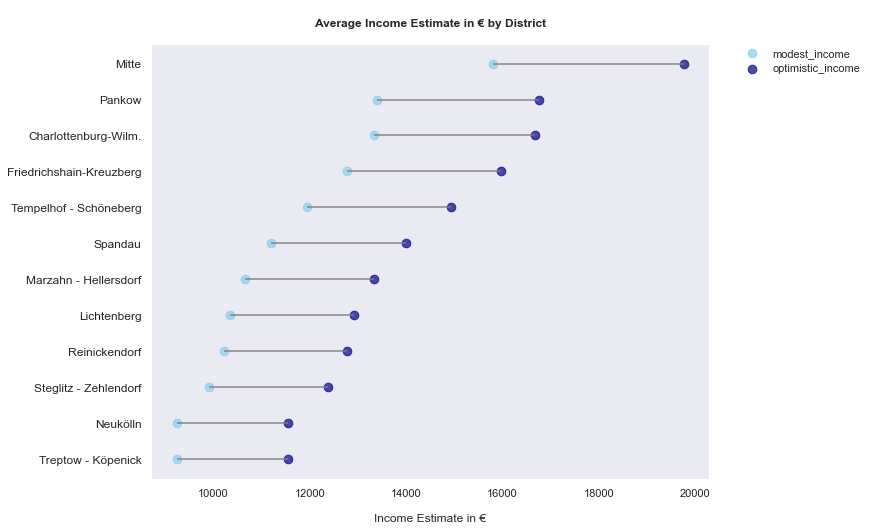

In [80]:
lollipop_with_2(df, 'Income Estimate in €', 'neighbourhood', 'modest_income', 'optimistic_income')

It appears to be that *Reinickendorf* benefits from rather low room rates, which lead to a high occupancy - as seen above. When it comes to earnings, Mitte is in the lead.

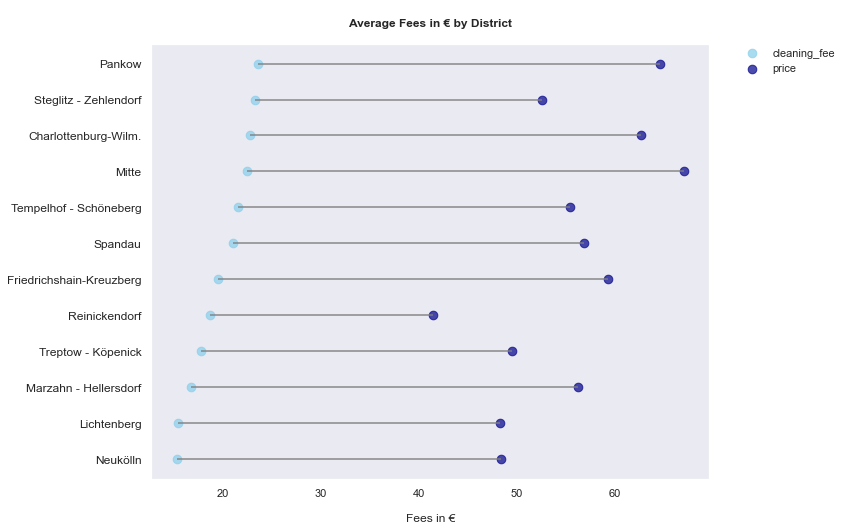

In [81]:
lollipop_with_2(df, 'Fees in €', 'neighbourhood', 'cleaning_fee', 'price')

*Lollipop Charts with one observation and one group highlighted*

In [82]:
def lollipop_with_highlight(dataframe, about, y_col, y_highlight, x_col):
    ''' Function that creates a lollipop chart with only one observation (x-value) 
    per group (y-value) and the option to highlight one of the grouped values. '''
    
    # set style
    sns.set_style("dark")
    
    # prepare data
    df_plot = dataframe[[y_col, x_col]].groupby(y_col).apply(lambda x: x.mean())
    df_plot.sort_values(x_col, inplace=True)
    df_plot.reset_index(inplace=True)

    # highlight district specified as y_highlight
    my_color = np.where(df_plot[y_col] == y_highlight, 'crimson', 'skyblue')
    my_size  = np.where(df_plot[y_col] == y_highlight, 70, 30)

    # draw plot
    fig, ax = plt.subplots(figsize=(8,8))
    ax.hlines (y=df_plot.index, xmin=0, xmax=df_plot[x_col], color=my_color, alpha=0.5, linewidth=2)
    ax.scatter(y=df_plot.index, x=df_plot[x_col], s=my_size, color=my_color, alpha=1, label=x_col)
    ax.legend()

    # title, label, ticks and xlim
    ax.set_title('\nAverage ' + about + ' by District\n', fontdict={'size':12, 'weight':'bold'})
    ax.set_xlabel('\n' + about)
    ax.set_yticks(df_plot.index)
    ax.set_yticklabels(df_plot[y_col], rotation=0, 
                       fontdict={'horizontalalignment': 'right', 'size':12})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

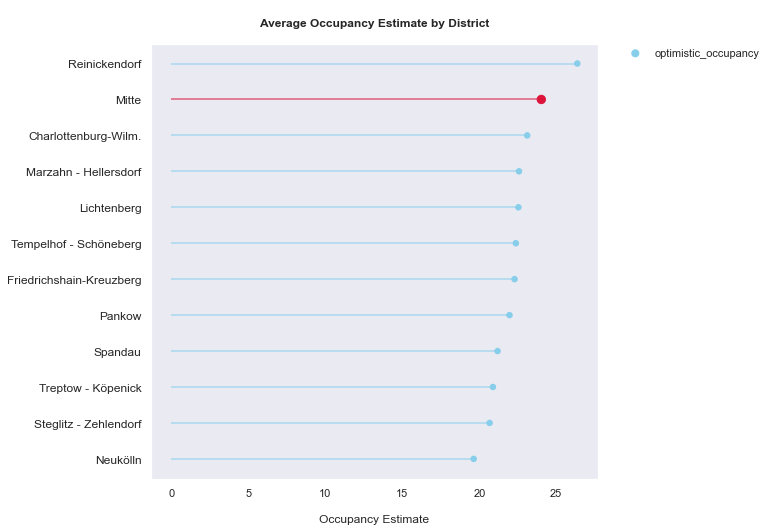

In [83]:
lollipop_with_highlight(df, 'Occupancy Estimate', 'neighbourhood', 'Mitte', 'optimistic_occupancy')

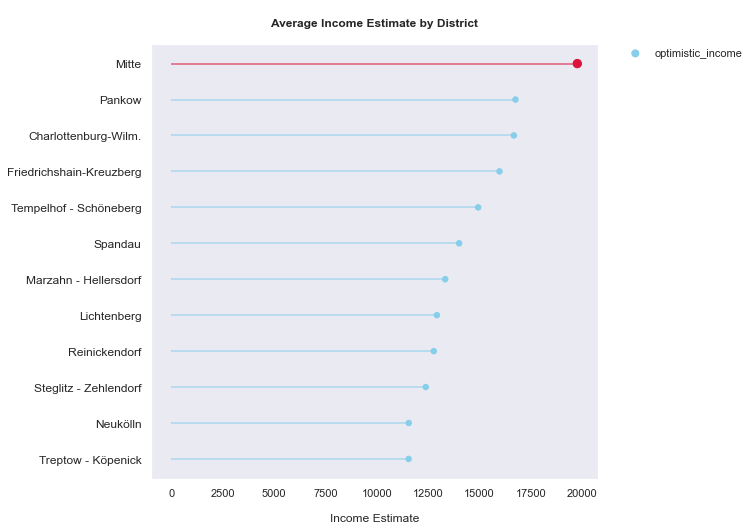

In [84]:
lollipop_with_highlight(df, 'Income Estimate', 'neighbourhood', 'Mitte', 'optimistic_income')

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.5. Demand by Capacity
<a id='3.5. Demand by Capacity'></a>

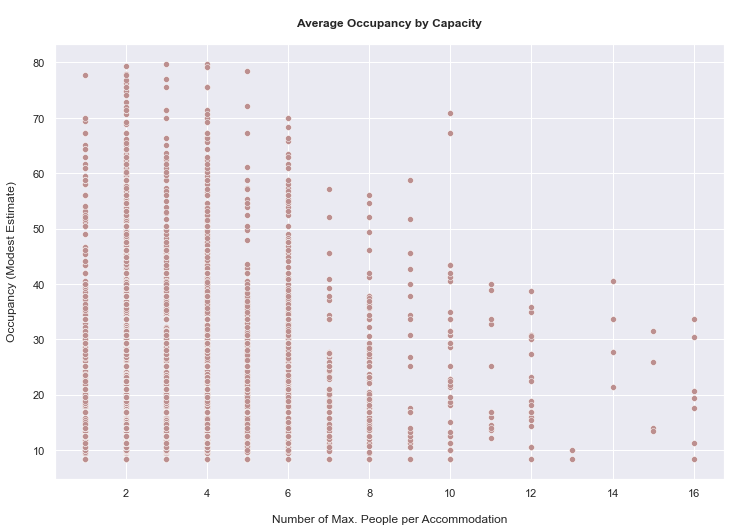

In [85]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,8))

sns.scatterplot(x="accommodates", y="modest_occupancy", color='rosybrown',  data=df)

plt.title('\nAverage Occupancy by Capacity\n', fontsize=12, fontweight='bold')
plt.xlabel('\nNumber of Max. People per Accommodation')
plt.ylabel('Occupancy (Modest Estimate)\n');

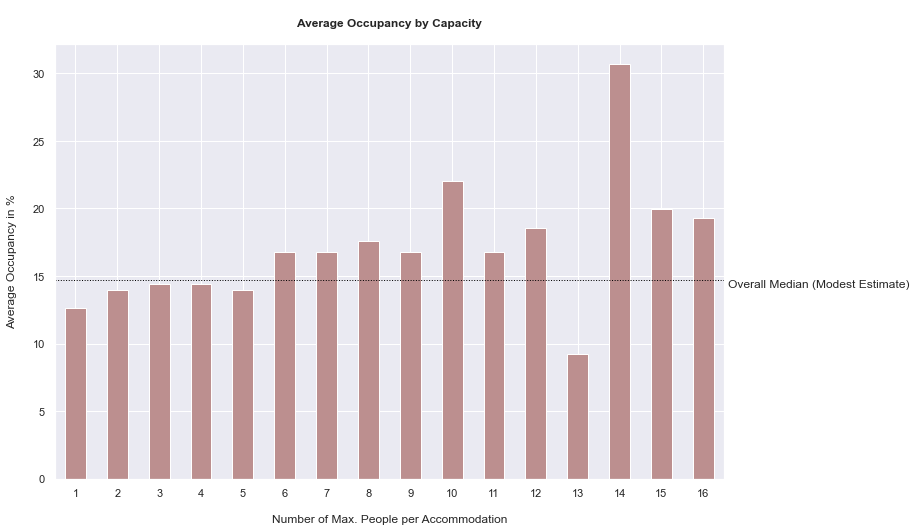

In [86]:
# group by accomodates and plot median occupancy
df.groupby('accommodates')['modest_occupancy']\
                          .median()\
                          .plot(kind='bar', figsize=(12,8), color='rosybrown')

# beautify the plot
plt.xlabel('\nNumber of Max. People per Accommodation', fontsize=12)
plt.xticks(rotation='horizontal')
plt.ylabel('Average Occupancy in %\n', fontsize=12)
plt.title('\nAverage Occupancy by Capacity\n', fontsize=12, fontweight='bold')

# draw and label the median value
plt.axhline(y=14.7, xmin=0, xmax=1, linewidth=1, linestyle=':', color='black')
plt.text(x=15.6, y=14.2, s='Overall Median (Modest Estimate)');

Generally, bigger homes seem to be sold more often than smaller ones. Perhaps this is due to the fact that a group might be able to save more money than 1-2 persons would by using Airbnb. It follows that accommodations with a bigger capacity enjoy greater popularity.

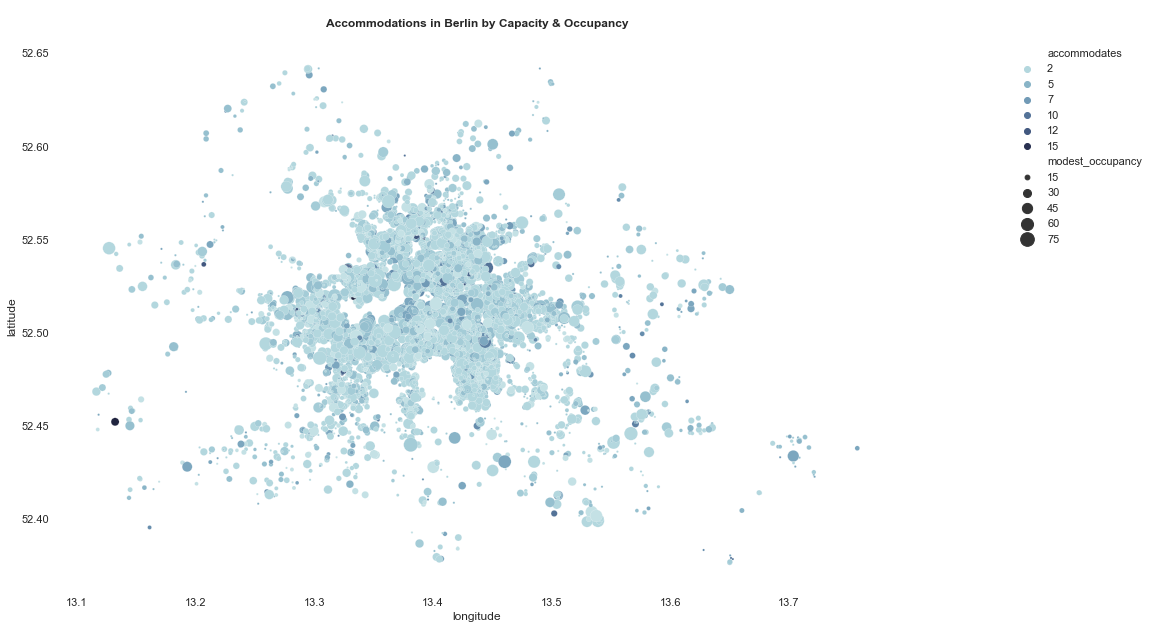

In [87]:
# prepare plot
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(15,10))

# draw scatter plot
ax = sns.scatterplot(x="longitude", y="latitude", size='modest_occupancy', sizes=(5, 200),
                     hue='accommodates', palette=cmap,  data=df)
ax.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0.)
plt.title('\nAccommodations in Berlin by Capacity & Occupancy\n', fontsize=12, fontweight='bold')

# remove spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.6. Wordclouds Reviews Summary
<a id='3.6. Wordclouds Reviews Summary'></a>

In [88]:
dropped = ['listing_id','reviewer_id','day','date']
df_rsumm_orig.drop(dropped,axis=1,inplace=True)

In [89]:
df_2015_comments = df_rsumm_orig[df_rsumm_orig['year'] == 2015]
df_2016_comments = df_rsumm_orig[df_rsumm_orig['year'] == 2016]
df_2017_comments = df_rsumm_orig[df_rsumm_orig['year'] == 2017]
df_2018_comments = df_rsumm_orig[df_rsumm_orig['year'] == 2018]

In [90]:
df_2015_sep_comments = df_rsumm_orig[(df_rsumm_orig['year'] == 2015) & (df_rsumm_orig['month'].str.contains("Sep"))]
df_2016_sep_comments = df_rsumm_orig[(df_rsumm_orig['year'] == 2016) & (df_rsumm_orig['month'].str.contains("Sep"))]
df_2017_sep_comments = df_rsumm_orig[(df_rsumm_orig['year'] == 2017) & (df_rsumm_orig['month'].str.contains("Sep"))]
df_2018_sep_comments = df_rsumm_orig[(df_rsumm_orig['year'] == 2018) & (df_rsumm_orig['month'].str.contains("Sep"))]

In [91]:
dropped = ['month']
df_2015_comments.drop(dropped,axis=1,inplace=True)
df_2016_comments.drop(dropped,axis=1,inplace=True)
df_2017_comments.drop(dropped,axis=1,inplace=True)
df_2018_comments.drop(dropped,axis=1,inplace=True)
df_2015_comments=df_2015_comments.reset_index(drop=True)
df_2016_comments=df_2016_comments.reset_index(drop=True)
df_2017_comments=df_2017_comments.reset_index(drop=True)
df_2018_comments=df_2018_comments.reset_index(drop=True)

df_2015_sep_comments.drop(dropped,axis=1,inplace=True)
df_2016_sep_comments.drop(dropped,axis=1,inplace=True)
df_2017_sep_comments.drop(dropped,axis=1,inplace=True)
df_2018_sep_comments.drop(dropped,axis=1,inplace=True)
df_2015_sep_comments=df_2015_sep_comments.reset_index(drop=True)
df_2016_sep_comments=df_2016_sep_comments.reset_index(drop=True)
df_2017_sep_comments=df_2017_sep_comments.reset_index(drop=True)
df_2018_sep_comments=df_2018_sep_comments.reset_index(drop=True)

In [92]:
df_list_year_wise = [df_2015_comments,df_2016_comments,df_2017_comments,df_2018_comments] #list of all frames

In [93]:
df_list_sep = [df_2015_sep_comments,df_2016_sep_comments,df_2017_sep_comments,df_2018_sep_comments] #list of all frames

In [94]:
from wordcloud import WordCloud,STOPWORDS

In [95]:
stopwords = set(STOPWORDS)

In [96]:
rev_comments_wc = WordCloud(
    background_color='white',
    max_words=100000, #if we dont give this it does for entire rows for that frame
    stopwords = stopwords
)
#instantinate word cloud objects
def show_wclouds(text):
    rev_comments_wc.generate(text)
    return(rev_comments_wc)

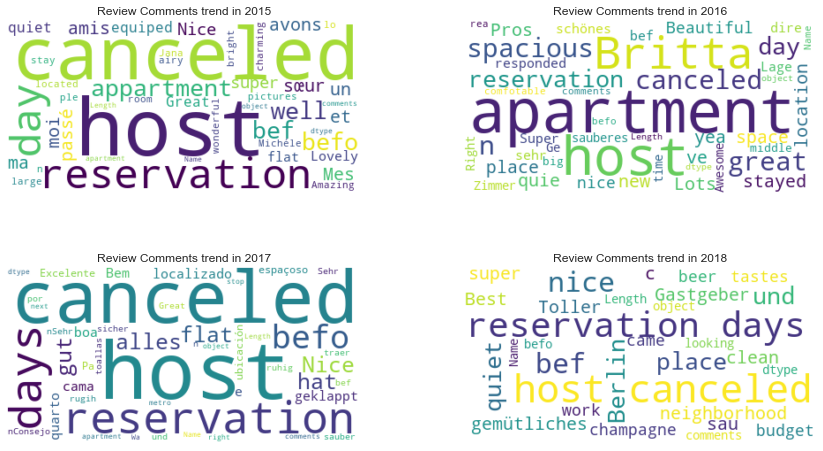

In [97]:
fig = plt.figure(figsize=(15, 6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4)
for i in range(0,len(df_list_year_wise)):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(show_wclouds(str(df_list_year_wise[i]['comments'])),interpolation='bilinear')
    ax.axis('off')
    title="Review Comments trend in "+str(df_list_year_wise[i]['year'].head(1).values[0])
    ax.set_title(title)

**Above indicates in 2016,2017 there were lot of visitors gave good review comments on properties but in 2015,2018 there were lot of cancellations as well **

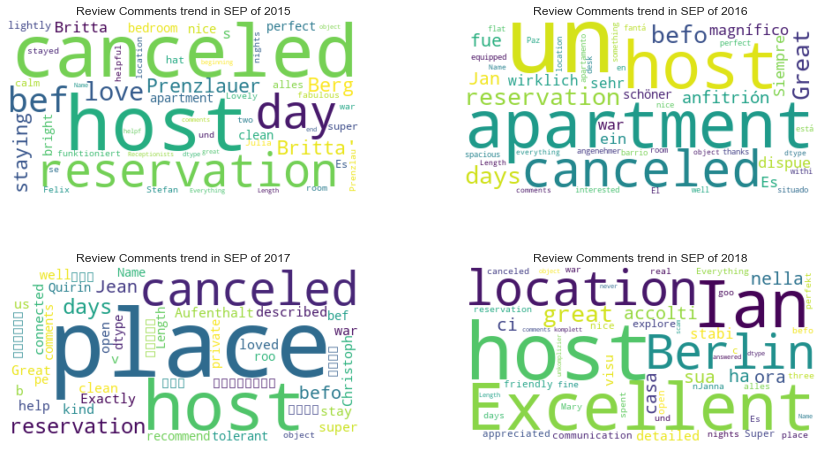

In [98]:
fig = plt.figure(figsize=(15, 6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4)
for i in range(0,len(df_list_sep)):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(show_wclouds(str(df_list_sep[i]['comments'])),interpolation='bilinear')
    ax.axis('off')
    title="Review Comments trend in SEP of "+str(df_list_sep[i]['year'].head(1).values[0])
    ax.set_title(title)

**Above indicates in SEP of each year (where we had most no. of  visitors), most of them gave good reviews**

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.7. Estimated Incomes vs Price
<a id='3.7. Estimated Income vs Price'></a>

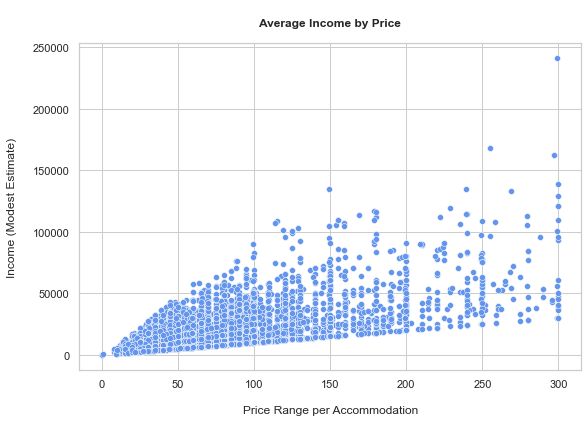

In [99]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(9,6))

sns.scatterplot(x="price", y="modest_income", color='cornflowerblue',  data=df)

plt.title('\nAverage Income by Price\n', fontsize=12, fontweight='bold')
plt.xlabel('\nPrice Range per Accommodation')
plt.ylabel('Income (Modest Estimate)\n');

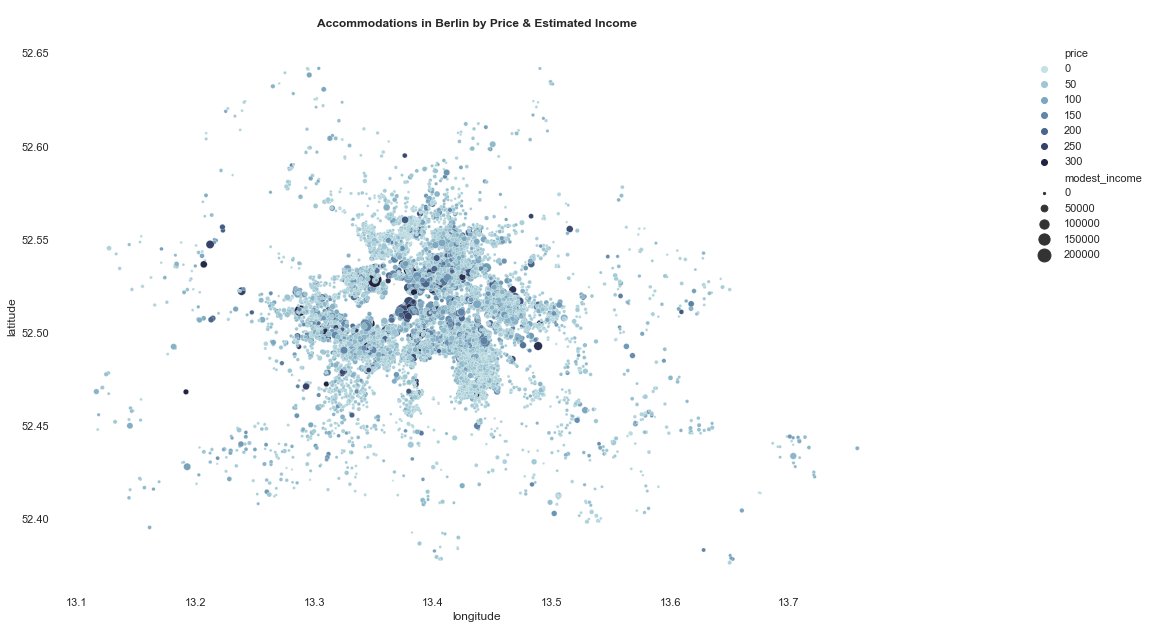

In [100]:
# prepare plot
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(15,10))

# draw scatter plot
ax = sns.scatterplot(x="longitude", y="latitude", size='modest_income', sizes=(5, 200),
                     hue='price', palette=cmap,  data=df)
ax.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0.)
plt.title('\nAccommodations in Berlin by Price & Estimated Income\n', fontsize=12, fontweight='bold')

# remove spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

In [101]:
#divide into 4 price range for accommodation
bin_labels_4 = ['Cheap', 'Affordable', 'HighEnd','Luxury']
df['Price_Group'] = pd.qcut(df['price'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels_4)

berlin_lat = df.latitude.mean()
berlin_long = df.longitude.mean()
colors = ["#ffefdb", "#a52a2a","#5f9ea0","#9932cc"] #antiquewhite1, brown, cadet blue, darkorchid

berlin_map = folium.Map(location=[berlin_lat, berlin_long], 
                        zoom_start=12, )

for index, berlin_row in df[['latitude', 'longitude', 'neighbourhood', 'Price_Group', 'modest_income']].sample(2222).iterrows():
    label = folium.Popup(f'{index}\n{berlin_row["Price_Group"]}\n{berlin_row["modest_income"]:.2f} Euro')
    if "Cheap" in berlin_row["Price_Group"]:
        color = colors[0]
    elif "Affordable" in berlin_row["Price_Group"]:
        color = colors[1]
    elif "HighEnd" in berlin_row["Price_Group"]:
        color = colors[2]
    else:
        color = colors[3]
    folium.CircleMarker(
        [berlin_row["latitude"], berlin_row["longitude"]],
        radius=(berlin_row["modest_income"]/10000),
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(berlin_map)  

berlin_map

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 4. Interpreting the Data
<a id='4. Interpreting the Data'></a>

**> Seasonality**

The high season for lodgings in Berlin is during late spring and early summer (specifically from May to July) and during the autumn months September and October. You could use your apartment yourself during the rest of year and offer it in these periods to get the most out of it.

**> Super Host**

To be a superhost is to be a cash machine. The occupancy rate in superhost lodgings is almost twice as high as in standard host lodgings, and the income is 60% higher.

**> Location, Location, Location**

If you don't want to live in the vibrant, loud center of Berlin yourselves - well, that's bad luck for you! That's precisely where tourists are looking to to rent Airbnb accommodations, particularly in *Mitte* or *Charlottenburg*, 
and are willing to pay more for them than for lodgings in outlying districts.

**> Capacity**

Travelers in (bigger) groups benefit much more from how much they save by using Airbnb than couples or small groups do. That implies that lodgings accommodating 6+ people tend to be more in-demand than smaller ones.

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 5. Appendix 
<a id='5. Appendix'></a>

All resources used in this notebook are listed below.

Data
- Inside Airbnb: http://insideairbnb.com/get-the-data.html

Occupancy Model
- http://insideairbnb.com/about.html
- https://www.airbnbcitizen.com/hosts-on-airbnb-have-welcomed-700000-guests-to-berlin-in-2017/
- https://www.airbnbcitizen.com/wp-content/uploads/2016/04/airbnb-community-berlin-en.pdf

Lollipop Plots
- https://python-graph-gallery.com/184-lollipop-plot-with-2-groups/
- https://python-graph-gallery.com/183-highlight-a-group-in-lollipop/
- https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#16.-Lollipop-Chart

Bubble Plots
- https://glowingpython.blogspot.com/2011/11/how-to-make-bubble-charts-with.html
- https://seaborn.pydata.org/examples/scatterplot_sizes.html

Inspiration
- https://towardsdatascience.com/airbnb-rental-listings-dataset-mining-f972ed08ddec
- https://towardsdatascience.com/improving-airbnb-yield-prediction-with-text-mining-9472c0181731
- https://www.kaggle.com/yogi045/how-to-become-top-earner-in-airbnb?utm_medium=email&utm_source=intercom&utm_campaign=datanotes-2019

Coloring Map
- https://www.w3schools.com/colors/colors_x11.asp

Folium HeatMap
- https://python-visualization.github.io/folium/plugins.html